In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

from sklearn.preprocessing import StandardScaler # tested with verison 0.20.3
from sklearn.neighbors import KNeighborsRegressor # tested with verison 0.20.3
from sklearn.linear_model import Lasso # tested with verison 0.20.3

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

In [2]:
class SampleLASSO:
    """
    Class for SampleLASSO algorithm
    """
    def __init__(self, datatype= 'Microarray', hyperparameter = 0.01, indices = [1]):
        """
        Initializes a SampleLASSO object
        """
        #stores gene data
        self.data_dict_ = {}
        self.set_datatype(datatype)
        self.set_hyperparameter(hyperparameter)
        self.indices_ = indices
        
    def get_hyperparameter(self):
        """
        Getter for hyperparameter
        
        :returns: float value of hyperparameter
        """
        return self.hyperparameter_
    
    def set_hyperparameter(self, hyperparameter):
        """
        Setter for hyperparameter
        
        :param hyperparameter: float value for hyperparameter
        """
        if not isinstance(hyperparameter, float):
            raise TypeError("Hyperparameter must be of type: float")
        if hyperparameter < 0:
            raise ValueError("Hyperparameter must be greater than or equal to 0.0")
        self.hyperparameter_ = hyperparameter
        
    def get_datatype(self):
        """
        Getter for datatype
        
        :returns: str value of datatype
        """
        return self.datatype_
        
    def set_datatype(self, datatype):
        """
        Setter for datatype
        
        :param datatype: str value for datatype 'Microarray', 'RNAseq'
        """
        if not isinstance(datatype, str):
            raise TypeError("Datatype parameter must be of type: str")
        if datatype.lower() not in ["microarray", "rnaseq"]:
            raise ValueError("Current supported datatypes are Microarray and RNAseq")
        self.datatype_ = datatype
        
    def get_indices(self):
        """
        Getter for datatype
        
        :returns: list[int] of indices
        """
        return self.indices_
    
    def set_indices(self, indices):
        """
        Setter for datatype
        
        :param indices: list[int] indicies to fit
        """
        self.indices_ = indices
        
    def fit():
        pass
        
    def predict():
        pass
        
    def load_data(self, train_file, test_file, gene_split_x_file, gene_split_y_file, split = None, split_file = None):
        """
        Loads data for LASSO
        
        :param train_file: str file pathway for training data
        :param test_file: str file pathway for testing data
        :param gene_split_x_file: str file pathway for x indices
        :param gene_split_y_file: str file pathway for y indices
        :param split: str
        :param split_file: str
        """
        
        # load indices
        x_gene_inds = np.loadtxt(gene_split_x_file, dtype=int)
        y_gene_inds = np.loadtxt(gene_split_y_file, dtype=int)

        # load the traning data
        train_data = np.load(train_file)
        if self.datatype_.lower() == 'rnaseq':
            train_data = np.arcsinh(train_data)
        train_x = train_data[:,x_gene_inds]
        self.data_dict_['Xtrn-'+self.datatype_] = train_x
        del train_x
        
        
        train_y = train_data[:,y_gene_inds]
        del train_data
        self.data_dict_['ytrn-'+self.datatype_] = train_y
        del train_y
        
        
        # load the test data
        test_data = np.load(test_file)
        if split == 'Val':
            trimmed_inds = np.load(split_file)
            test_data = test_data[trimmed_inds,:]
        if self.datatype_ == 'RNAseq':
            test_data = np.arcsinh(tstdata)
        test_x = test_data[:,x_gene_inds]
        test_y = test_data[:,y_gene_inds]
        self.data_dict_['Xtst-'+self.datatype_] = test_x
        self.data_dict_['ytst-'+self.datatype_] = test_y
        
    def reorder_and_transpose(self):
        """
        Transposes data for SampleLASSO
        """

        self.data_dict_['ytrn-'+self.datatype_], self.data_dict_['Xtst-'+self.datatype_] = self.data_dict_['Xtst-'+self.datatype_], self.data_dict_['ytrn-'+self.datatype_]

        for akey in self.data_dict_:
            self.data_dict_[akey] = np.transpose(self.data_dict_[akey])

    
    def stdscale_data(self):
        """
        Scales data for SampleLASSO
        """

        std_scale = StandardScaler().fit(self.data_dict_['Xtrn-'+self.datatype_])
        # transform the Xtrn data
        self.data_dict_['Xtrn-'+self.datatype_] = std_scale.transform(self.data_dict_['Xtrn-'+self.datatype_])

        # use Xtrn scale to transform Val data
        self.data_dict_['Xtst-'+self.datatype_] = std_scale.transform(self.data_dict_['Xtst-'+self.datatype_])
        
    def preprocess(self):
        """
        Preprocesses data for SampleLASSO
        """
        self.reorder_and_transpose()
        self.stdscale_data()
        
    def initialize_regressor(self):
        self.reg_ = Lasso(alpha=self.hyperparameter_,fit_intercept=True,normalize=False,precompute=False,
                     copy_X=True,max_iter=1000,tol=0.001,warm_start=False,positive=False,
                     random_state=None,selection='random')
        
        
    def regress(self, indices=None):

        self.initialize_regressor()
        self.y_preds_ = []
        self.regression_results_ = []
        
        if indices is None:
            indicies = self.indices_
        
        for amodel in indices:
            self.reg_.fit(self.data_dict_['Xtrn-'+self.datatype_],self.data_dict_['ytrn-'+self.datatype_][:,amodel])
            y_pred = self.reg_.predict(self.data_dict_['Xtst-'+self.datatype_])
            mean_sqr_error = mean_squared_error(self.data_dict_['ytst-'+self.datatype_][:,amodel], y_pred)
            self.regression_results_.append({'index': amodel,
                                             'r_sqr': r2_score(self.data_dict_['ytst-'+self.datatype_][:,0], y_pred),
                                             'rmse': np.sqrt(mean_sqr_error),
                                             'nrmse': np.sqrt(mean_sqr_error/np.average(self.data_dict_['ytst-'+self.datatype_][:,amodel]))
                                            })
            
    def regression_results(self):
        return self.regression_results_

In [3]:
test = SampleLASSO()

train_file = 'data/data/Microarray_Trn_Exp.npy'
test_file = 'data/data/Microarray_tst_Exp.npy'
gene_x = 'data/data/LINCS_Xgenes_inds.txt'
gene_y = 'data/data/LINCS_Ygenes_inds.txt'

test.load_data(train_file, test_file, gene_x, gene_y)
test.preprocess()
test.regress([1, 4, 6, 100])
test.regression_results()

C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler in

[{'index': 1,
  'r_sqr': 0.9784736171212836,
  'rmse': 0.30805588066457057,
  'nrmse': 0.1234757339361855},
 {'index': 4,
  'r_sqr': 0.5893748368231098,
  'rmse': 0.4189101790157947,
  'nrmse': 0.16758651885257073},
 {'index': 6,
  'r_sqr': 0.6215901995740838,
  'rmse': 0.4187980870009433,
  'nrmse': 0.16777850226055335},
 {'index': 100,
  'r_sqr': 0.3481938477665415,
  'rmse': 0.6901165918937193,
  'nrmse': 0.27577830475276394}]

15991
15991
0.9784424160770712
0.2061486947395404
0.09472455777128769
15991
15991


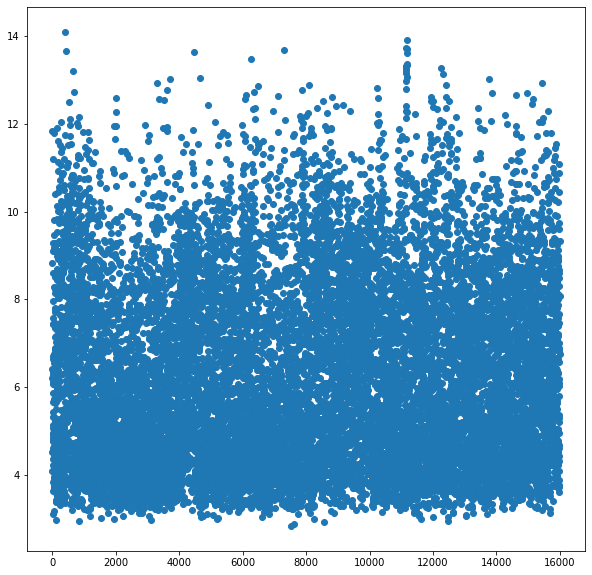

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
print(len(test.ypreds))
print(len(test.data_dict_['ytst-'+test.datatype_][:,0]))
print(r2_score(test.data_dict_['ytst-'+test.datatype_][:,0], test.ypreds))
print(mean_absolute_error(test.data_dict_['ytst-'+test.datatype_][:,0], test.ypreds))
print(mean_squared_error(test.data_dict_['ytst-'+test.datatype_][:,0], test.ypreds))
print(len(test.ypreds))
y = np.linspace(0, 15991, 15991)
print(len(y))
plt.figure(figsize=(10,10))
plt.scatter(y, test.ypreds)

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html

.

C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 387 iterations, alpha=8.148e-03, previous alpha=8.144e-03, with an active set of 240 regressors.
  warnings.warn(


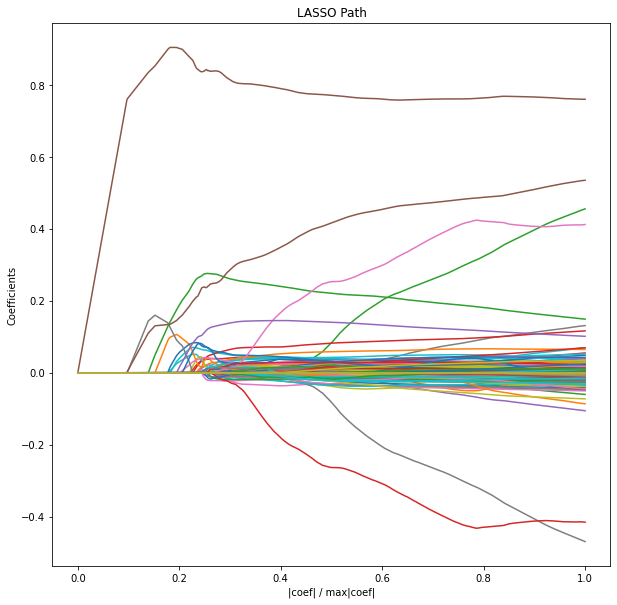

In [24]:
from sklearn import linear_model

_, _, coefs = linear_model.lars_path(test.data_dict_['Xtrn-'+test.datatype_],test.data_dict_['ytrn-'+test.datatype_][:,1], method="lasso", verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]


plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
#plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
#plt.savefig('LASSOpath.png', bbox_inches='tight')
plt.savefig('LASSOpath.png')

## Gene LASSO

In [2]:
reg = Lasso(alpha=0.01,fit_intercept=True,normalize=False,precompute=False,
                     copy_X=True,max_iter=1000,tol=0.001,warm_start=False,positive=False,
                     random_state=None,selection='random')
data_dict ={}
train_file = 'data/data/Microarray_Trn_Exp.npy'
test_file = 'data/data/Microarray_tst_Exp.npy'
gene_x = 'data/data/LINCS_Xgenes_inds.txt'
gene_y = 'data/data/LINCS_Ygenes_inds.txt'
indices = [1, 4, 6, 100]
datatype='Microarray'
# load indices
x_gene_inds = np.loadtxt(gene_x, dtype=int)
y_gene_inds = np.loadtxt(gene_y, dtype=int)

# load the traning data
train_data = np.load(train_file)
if datatype.lower() == 'rnaseq':
    train_data = np.arcsinh(train_data)
train_x = train_data[:,x_gene_inds]
data_dict['Xtrn-'+datatype] = train_x
del train_x


train_y = train_data[:,y_gene_inds]
del train_data
data_dict['ytrn-'+datatype] = train_y
del train_y


# load the test data
test_data = np.load(test_file)

test_x = test_data[:,x_gene_inds]
test_y = test_data[:,y_gene_inds]
data_dict['Xtst-'+datatype] = test_x
data_dict['ytst-'+datatype] = test_y
        
for amodel in indices:
    reg.fit(data_dict['Xtrn-'+datatype],data_dict['ytrn-'+datatype][:,amodel])
    ypreds = reg.predict(data_dict['Xtst-'+datatype])
    print('Index: {}'.format(amodel))
    print(ypreds)
    print("r2 score:", r2_score(data_dict['ytst-'+datatype][:,amodel], ypreds))
    print("mean ab error:", mean_absolute_error(data_dict['ytst-'+datatype][:,amodel], ypreds))
    print("rmse:", np.sqrt(mean_squared_error(data_dict['ytst-'+datatype][:,amodel], ypreds)))
    print("nrmse:", np.sqrt(mean_squared_error(data_dict['ytst-'+datatype][:,amodel], ypreds))/np.average(data_dict['ytst-'+datatype][:,amodel]))
    print()

C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Index: 1
[4.17739165 4.16513286 4.24965847 ... 5.1210569  4.98135037 5.18971537]
r2 score: 0.7878400126174399
mean ab error: 0.3245033471379683
rmse: 0.473831268843055
nrmse: 0.10287182539832976



C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Index: 4
[5.32380466 5.29019945 5.35935143 ... 4.79730616 4.54691735 4.82016146]
r2 score: 0.6791951228042832
mean ab error: 0.32726230846499715
rmse: 0.4480670492075468
nrmse: 0.08029916484958903



C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Index: 6
[4.31517293 4.33035919 4.33485801 ... 4.48106856 4.45200214 4.45053345]
r2 score: 0.6313079109712527
mean ab error: 0.13343681437046528
rmse: 0.18954631288220208
nrmse: 0.042944247485843974



C:\Users\Aidan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Index: 100
[4.20503017 4.23384912 4.28708344 ... 5.59609348 5.29805116 5.55324527]
r2 score: 0.7731786609645823
mean ab error: 0.2501353628261149
rmse: 0.3782456421810566
nrmse: 0.08151990773053079

